In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import skimage.io
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from tqdm import tqdm
import seaborn as sb

In [3]:
ROOT_DIR = "/raid/data/cellpainting/TAORF/"
metadata = pd.read_csv(os.path.join(ROOT_DIR, "inputs/metadata/index.csv"))

# Read all cell locations
## Compute the mean intensity in a 32x32 square

In [4]:
image_values = {}
for key,row in tqdm(metadata.iterrows()):
    loc_file = os.path.join(
        ROOT_DIR, 
        "inputs/locations/{}/{}-{}-Nuclei.csv".format(row.Metadata_Plate, row.Metadata_Well, row.Metadata_Site)
    )
    if not os.path.isfile(loc_file):
        continue

    locations = pd.read_csv(loc_file)
    
    img_file = os.path.join(ROOT_DIR + "inputs/images/" + row.DNA)
    img = skimage.io.imread(img_file)
    
    nucleus_values = {}
    for k,r in locations.iterrows():
        r0,r1 = r.Nuclei_Location_Center_Y - 16, r.Nuclei_Location_Center_Y + 16
        c0,c1 = r.Nuclei_Location_Center_X - 16, r.Nuclei_Location_Center_X + 16
        nucleus_values[k] = np.mean(img[r0:r1, c0:c1])
        
    image_values[key] = nucleus_values

17280it [03:08, 91.77it/s] 


# Organize the results in a dataframe

In [5]:
all_data = []
for x in image_values.keys():
    df = pd.DataFrame(data=image_values[x].keys(), columns=["loc"])
    df["mean"] = image_values[x].values()
    df["image"] = x
    all_data.append(df)
all_data = pd.concat(all_data).reset_index()

In [6]:
remove = []
remove.append(all_data[all_data["mean"].isna()])

valid_data = all_data[~all_data["mean"].isna()]
valid_data = valid_data.sort_values(by="mean").reset_index()

# Plot the distribution of mean intensities

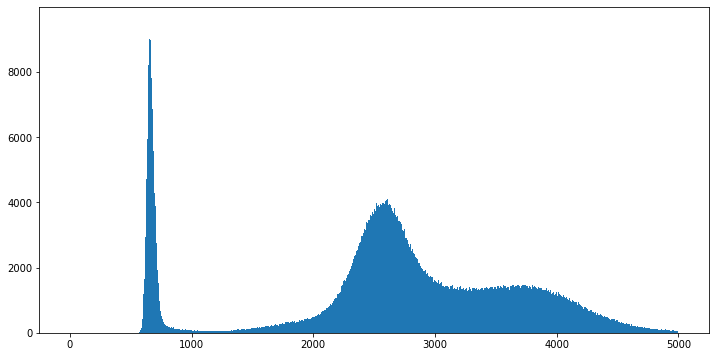

In [7]:
plt.figure(figsize=(12,6))
h = plt.hist(valid_data["mean"], bins=1000, range=[0,5000])

# Identify the first isolated cluster of cells

In [8]:
# Set a threshold
cutoff = 1200

remove.append(valid_data[valid_data["mean"] <= cutoff])
valid_data = valid_data[valid_data["mean"] > cutoff]

remove = pd.concat(remove)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


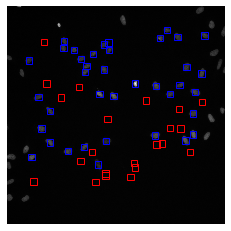

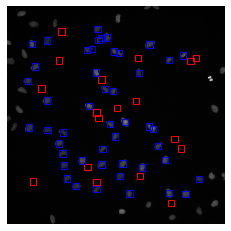

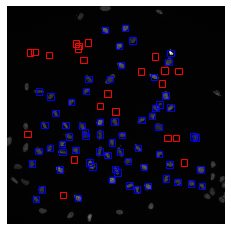

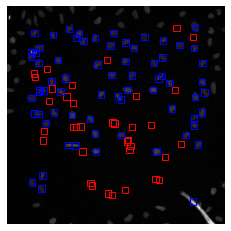

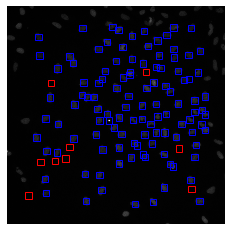

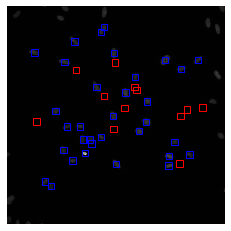

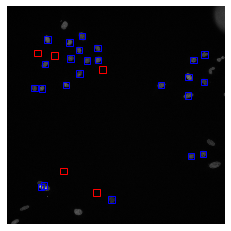

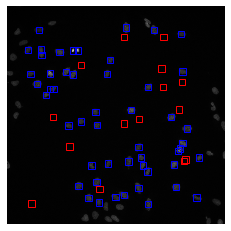

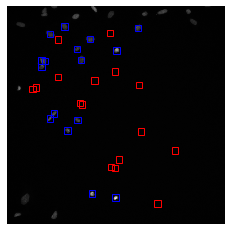

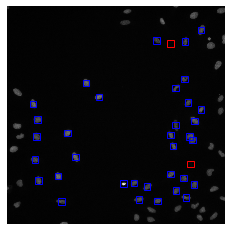

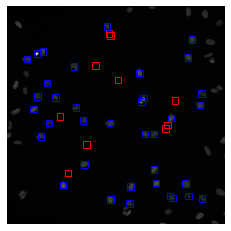

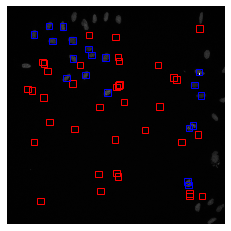

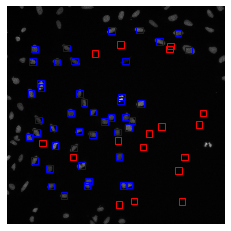

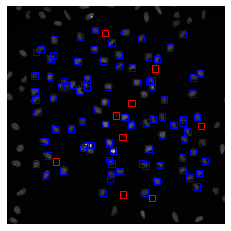

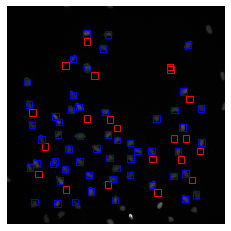

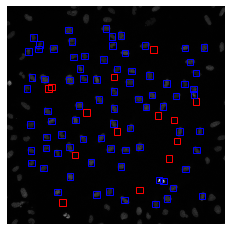

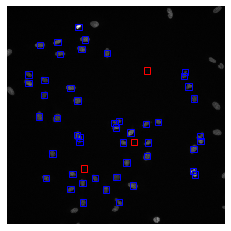

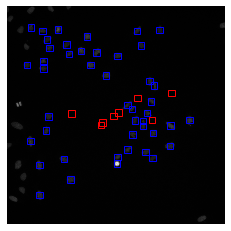

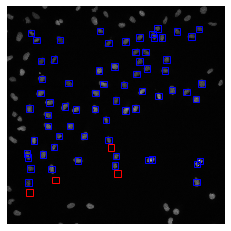

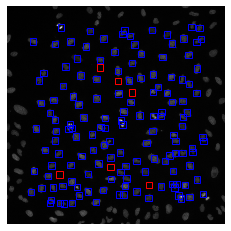

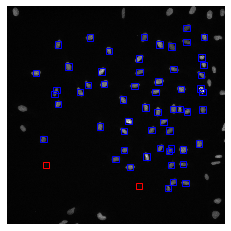

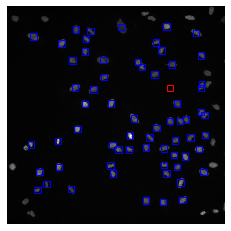

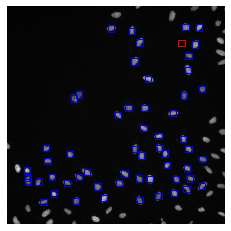

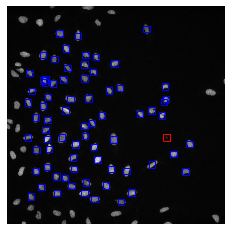

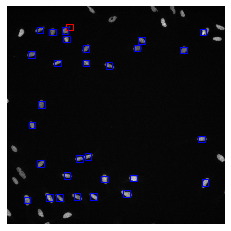

In [9]:
# Visualize some example outliers
count = 0
for img_key in remove.image.unique():
    count += 1
    if count % 500 != 0:
        continue
        
    img_file = os.path.join(ROOT_DIR + "inputs/images/" + metadata.loc[int(img_key), "DNA"])
    img = skimage.io.imread(img_file)
    loc_file = os.path.join(
        ROOT_DIR, 
        "inputs/locations/{}/{}-{}-Nuclei.csv".format(
            metadata.loc[int(img_key), "Metadata_Plate"], 
            metadata.loc[int(img_key), "Metadata_Well"], 
            metadata.loc[int(img_key), "Metadata_Site"]
        )
    )
    locs = pd.read_csv(loc_file)
    df_w = remove.query("image == " + str(img_key))
    df_r = valid_data.query("image == " + str(img_key))
    
    box_size = 32
    fig, ax = plt.subplots(1, figsize=(4,4))
    ax.imshow(img, cmap="gray")
    for key, row in df_w.iterrows():
        rect = patches.Rectangle(
            (locs.loc[row["loc"],"Nuclei_Location_Center_X"] - box_size/2,
             locs.loc[row["loc"],"Nuclei_Location_Center_Y"] - box_size/2),
            box_size, box_size, linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
    for key, row in df_r.iterrows():
        rect = patches.Rectangle(
            (locs.loc[row["loc"],"Nuclei_Location_Center_X"] - box_size/2,
             locs.loc[row["loc"],"Nuclei_Location_Center_Y"] - box_size/2),
            box_size, box_size, linewidth=1, edgecolor='b', facecolor='none'
        )
        ax.add_patch(rect)

    ax.set_axis_off()

# Remove outliers (spurious locations)

In [10]:
STOP and THINK

NameError: name 'STOP' is not defined

## Warning: this should only be run once

In [11]:
for i in remove.image.unique():
    df_ = remove.query("image == " + str(i))
    loc_file = os.path.join(
        ROOT_DIR, 
        "inputs/locations/{}/{}-{}-Nuclei.csv".format(
            metadata.loc[i, "Metadata_Plate"], 
            metadata.loc[i, "Metadata_Well"], 
            metadata.loc[i, "Metadata_Site"]
        )
    )
    locs = pd.read_csv(loc_file)
    locs = locs[~locs.index.isin([x for x in df_["loc"]])]
    locs.to_csv(loc_file, index=False)

In [12]:
print("Removed",len(remove),"cell locations from the dataset")
print("Percent:", 100*(len(remove)/len(all_data)),"%")
print("Total valid locations preserved:", len(all_data) - len(remove))

Removed 140766 cell locations from the dataset
Percent: 13.748505660908089 %
Total valid locations preserved: 883098
